In [1]:
from src.Metrics import batch_metrics
from src.Models import NetworkColor, load_model
from src.Datasets import CocoDataset
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from skimage import color
from tqdm import tqdm
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device used : {device}")

device used : cuda


In [2]:
model = NetworkColor().to(device)
load_model(model, "models/NetworkColor.pt")

NetworkColor(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3), dilation=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, 

In [3]:
root_dir = "./ressources"

transform = v2.Compose([
	color.rgb2lab,
	v2.ToImage(),
	v2.ToDtype(torch.float32),
	v2.Resize((128,128), antialias=True),
	v2.Normalize(((-126.,-126.,0.)), ((256.,256.,100.)))
])

UnNormalize = v2.Compose([
	v2.Normalize((0.,0.,0.), (1/256.,1/256.,1/100.)),
	v2.Normalize((126.,126.,0.), (1.,1.,1.))
])

train_dataset = CocoDataset(root=root_dir, split="train", transform=transform)
test_dataset = CocoDataset(root=root_dir, split="test", transform=transform)

batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
from src.Metrics import compute_psnr, compute_ssim

img1, img2 = train_dataset[0]
img1, img2 = img1.numpy(), img2.numpy()
print(img1.shape, img2.shape)
print(compute_psnr(img2, img2))
print(compute_ssim(img2, img2))

(1, 128, 128) (3, 128, 128)
inf
1.0


/home/mmarzloff/Travail/computer_vision/Projet/.venv/lib/python3.11/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)


In [5]:
def metrics_loop(dataloader, model, metric = "PSNR"):
	size = len(dataloader.dataset)
	model = model.to(device)
	model.eval()
	total = 0
	with torch.no_grad():
		for X, y in tqdm(dataloader, desc=metric):
			total += batch_metrics(model, X, y, device, metric)
	return total / size

In [6]:
# Compute metrics
PSNR_train = metrics_loop(train_loader, model, metric="PSNR")
SSIM_train = metrics_loop(train_loader, model, metric="SSIM")
PSNR_test = metrics_loop(test_loader, model, metric="PSNR")
SSIM_test = metrics_loop(test_loader, model, metric="SSIM")

print(f"PSNR train : {PSNR_train}")
print(f"PSNR test : {PSNR_test}")
print(f"SSIM train : {SSIM_train}")
print(f"SSIM test : {SSIM_test}")


SSIM: 100%|██████████| 20/20 [03:42<00:00, 11.13s/it]

PSNR train : 18.63436775506013
PSNR test : 18.294813294765916
SSIM train : 0.6264226610497289
SSIM test : 0.6245758330464363


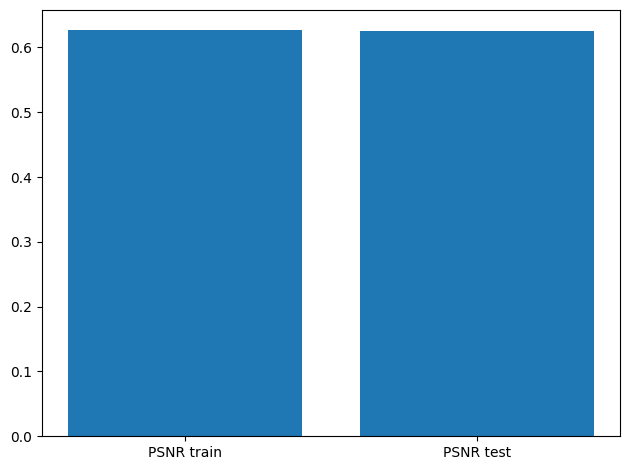

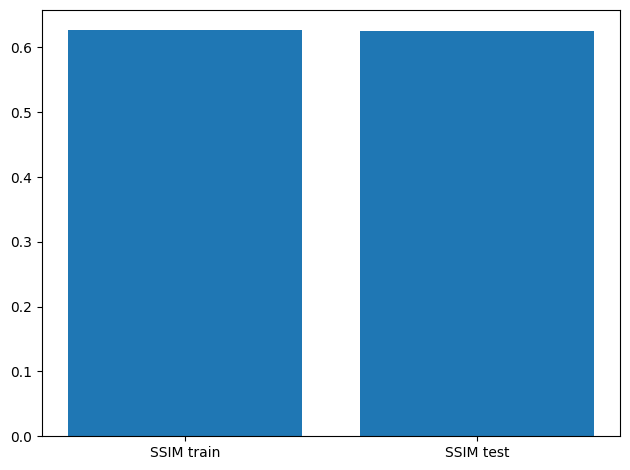

In [10]:
import matplotlib.pyplot as plt

plt.bar(["PSNR train", "PSNR test"], [SSIM_train, SSIM_test])
plt.tight_layout()
plt.figure()
plt.bar(["SSIM train", "SSIM test"], [SSIM_train, SSIM_test])
plt.tight_layout()